<center><img src='https://raw.githubusercontent.com/Jangrae/img/master/ml_python.png' width=600/></center>

<img src = "https://github.com/Jangrae/img/blob/master/mobile2.png?raw=true" width=800 align="left"/>

# 실습 내용

- 다양한 알고리즘으로 모델을 만들고 성능을 예측합니다.
- 성능이 좋을 것으로 판단된 모델의 성능을 튜닝합니다.
- 튜닝된 모델의 성능을 평가합니다.

# 1.환경 준비

- 기본 라이브러리와 대상 데이터를 가져와 이후 과정을 준비합니다.

In [10]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'

In [11]:
# 데이터 불러오기
path = 'https://raw.githubusercontent.com/jangrae/csv/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data['CHURN'] = data['CHURN'].map({'STAY':0, 'LEAVE': 1})

# 2.데이터 이해

- 분석할 데이터를 충분히 이해할 수 있도록 다양한 탐색 과정을 수행합니다.

In [12]:
# 데이터 살펴보기
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**데이터 설명**

- COLLEGE: 대학 졸업여부
- INCOME: 연수입
- OVERAGE: 월평균 초과사용 시간(분)
- LEFTOVER: 월평균 잔여시간비율(%)
- HOUSE: 집값
- HANDSET_PRICE: 스마트폰 가격
- OVER_15MINS_CALLS_PER_MONTH: 월평균 장기통화(15분이상) 횟수
- AVERAGE_CALL_DURATION: 평균 통화 시간
- REPORTED_SATISFACTION: 만족도 설문조사 결과
- REPORTED_USAGE_LEVEL: 사용도 자가진단 결과
- CONSIDERING_CHANGE_OF_PLAN: 향후 변경계획 설문조사 결과
- CHURN: 이탈(번호이동) 여부

In [13]:
# 기초통계정보 확인
data.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250,0.492600
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558,0.499958
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000,0.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000,0.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000,0.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000,1.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000,1.000000


# 3.데이터 준비

- 전처리 과정을 통해 머신러닝 알고리즘에 사용할 수 있는 형태의 데이터를 준비합니다.

**1) 변수 제거**

In [14]:
# 제거 대상: id
del_cols = 'id'

# 변수 제거
data = data.drop(del_cols, axis =1)

# 확인
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,0,31953,0,6,313378,161,0,4,unsat,little,no,0
1,1,36147,0,13,800586,244,0,6,unsat,little,considering,0
2,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,0
3,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,1
4,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,0


**2) x, y 분리**

In [15]:
# Target 설정
target = 'CHURN'

# 데이터 분리
x = data.drop(target, axis =1)
y = data[target]


**3) 가변수화**

In [16]:
# 가변수화 대상: REPORTED_SATISFACTION, REPORTED_USAGE_LEVEL, CONSIDERING_CHANGE_OF_PLAN
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']

# 가변수화
x = pd.get_dummies(data = x , columns = dumm_cols , drop_first = True )

# 확인
x.head(2)

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,0,1,0,0,0,1,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,0,1,0,0,0,1,0,0,1,0,0,0


**4) 정규화**

In [17]:
# 정규화
x = (x - x.min()) / (x.max() - x.min())

# 확인
x.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0.0,0.085343,0.005935,0.067416,0.192208,0.040312,0.000000,0.214286,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.115305,0.005935,0.146067,0.765398,0.148244,0.000000,0.357143,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.051909,0.688427,0.000000,0.182410,0.092328,0.551724,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.714858,0.118694,0.370787,0.750868,0.845254,0.103448,0.071429,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.065783,0.623145,0.955056,0.087979,0.144343,0.724138,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


**5) 학습용, 평가용 데이터 분리**

In [19]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=2022)

# 4.성능 예측

- 여러 알고리즘으로 모델을 만들고 K-Fold CV로 성능을 예측합니다.
- 하이퍼파라미터를 설정하지 않고 진행합니다.
- 각 모델의 성능 정보를 수집해 마지막에 비교합니다.

In [ ]:
# xgboost 설치
# pip install xgboost

In [ ]:
# lightgbm 설치
# pip install lightgbm

- 이후 사용할 함수를 모두 불러옵니다.

In [20]:
# 불러오기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

**1) KNN**

- KNN 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [26]:
# 선언하기
from sklearn.neighbors import KNeighborsClassifier
model_KNN  = KNeighborsClassifier(n_neighbors=5)

In [27]:
# 성능예측
cv_score = cross_val_score(model_KNN,x_train,y_train, cv = 10)

In [28]:
# 결과확인
print(cv_score)
print('평균 :' ,cv_score.mean())

[0.603125 0.595625 0.606875 0.615625 0.581875 0.635625 0.593125 0.603125
 0.605    0.61875 ]
평균 : 0.6058750000000002


In [29]:
# 결과수집
result = {}
result['KNN'] = cv_score.mean()

**2) Decision Tree**

- Decision Tree 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [31]:
# 선언하기
model_DT = DecisionTreeClassifier(max_depth =5 ,random_state=2022)


In [33]:
# 성능예측
cv_score = cross_val_score(model_DT, x_train, y_train,cv=10)

In [34]:
# 결과확인
print(cv_score)
print('평균 :' ,cv_score.mean())

[0.7125   0.6925   0.6875   0.71625  0.67375  0.718125 0.693125 0.6825
 0.679375 0.706875]
평균 : 0.69625


In [35]:
# 결과수집
result['Decision Tree'] = cv_score.mean()

**3) Logistic Regression**

- Logistic Regression 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [38]:
# 선언하기
model_LR =  LogisticRegression(random_state=2022)

In [39]:
# 성능예측
cv_score = cross_val_score(model_LR,x_train, y_train, cv =10 )

In [40]:
# 결과확인
print(cv_score)
print('평균 :' ,cv_score.mean())

[0.643125 0.64125  0.648125 0.6675   0.621875 0.653125 0.64375  0.62875
 0.618125 0.6225  ]
평균 : 0.6388124999999999


In [41]:
# 결과수집
result['Logistic Regression'] = cv_score.mean()

**4) Random Forest**

- Random Forest 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [42]:
# 선언하기
model_RF = RandomForestClassifier(max_depth=5, random_state=2022)

In [43]:
# 성능예측
cv_score = cross_val_score(model_RF, x_train, y_train ,cv=10)

In [44]:
# 결과확인
print(cv_score)
print('평균 :' ,cv_score.mean())

[0.699375 0.681875 0.69125  0.71875  0.68125  0.70625  0.7      0.680625
 0.683125 0.683125]
평균 : 0.6925625000000002


In [45]:
# 결과수집
result['Random Forest'] = cv_score.mean()

**5) XGBoost**

- XGBoost 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [46]:
# 선언하기
model_XGB = XGBClassifier()

In [48]:
# 성능예측
cv_score = cross_val_score(model_XGB ,x_train, y_train ,cv=10 )

In [49]:
# 결과확인
print(cv_score)
print('평균 :' ,cv_score.mean())

[0.686875 0.671875 0.68375  0.7125   0.6825   0.693125 0.695    0.6725
 0.683125 0.693125]
평균 : 0.6874375


In [50]:
# 결과수집
result['XGBoost'] = cv_score.mean()

**6) LightGBM**

- LightGBM 알고리즘으로 모델링하고 K-Fold CV로 성능을 검증합니다.

In [51]:
# 선언하기
model_LGBM = LGBMClassifier()

In [52]:
# 성능예측
cv_score = cross_val_score(model_LGBM,x_train, y_train,cv=10)

In [53]:
# 결과확인
print(cv_score)
print('평균 :' ,cv_score.mean())

[0.7      0.693125 0.6925   0.7125   0.66875  0.70875  0.69875  0.68625
 0.685    0.7     ]
평균 : 0.6945625000000001


In [54]:
# 결과수집
result['LightGBM'] = cv_score.mean()

# 5.결과 확인

- 예측된 각 모델의 성능을 비교합니다.

In [64]:
result

{'KNN': 0.6058750000000002,
 'Decision Tree': 0.69625,
 'Logistic Regression': 0.6388124999999999,
 'Random Forest': 0.6925625000000002,
 'XGBoost': 0.6874375,
 'LightGBM': 0.6945625000000001}

In [55]:
# 성능 비교
print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)

KNN 0.606
Decision Tree 0.696
Logistic Regression 0.639
Random Forest 0.693
XGBoost 0.687
LightGBM 0.695


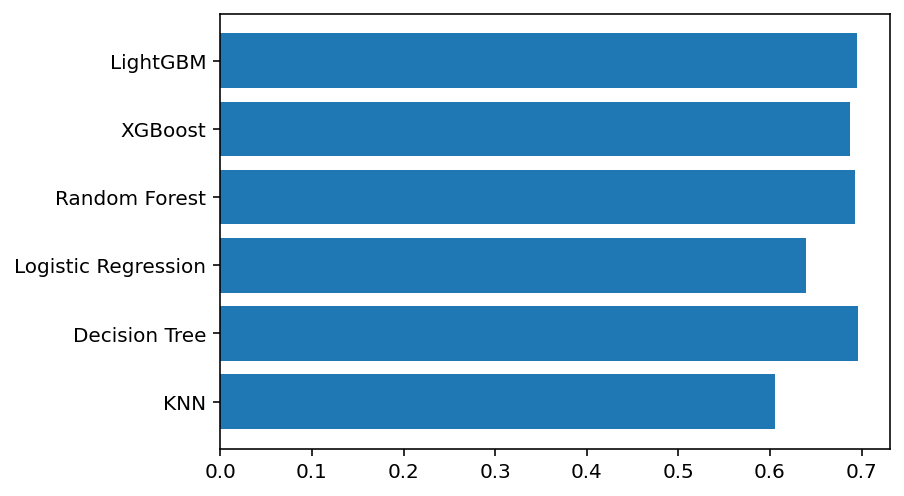

In [56]:
# 성능 시각화 비교
plt.barh(list(result.keys()), result.values())
plt.show()

# 6.성능 튜닝

- 위에서 성능이 가장 좋을 것으로 예측된 모델을 튜닝합니다.
- 본 실습에서는 LightGBM 모델 성능을 튜닝합니다.

In [65]:
# 기본 모델 선언
model_gbm = LGBMClassifier(n_estimators=200)

# 파라미터 지정
  # max_depth: range(1, 21)
params = {'max_depth': range(1,21)}

# 모델 선언
model = GridSearchCV(model_gbm,
                     params,
                     cv=10,
                     scoring = 'accuracy'
                    )




In [66]:
# 학습하기(많은 시간이 소요될 수 있음)
model.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=LGBMClassifier(n_estimators=200),
             param_grid={'max_depth': range(1, 21)}, scoring='accuracy')

In [67]:
# 최적 파라미터, 예측 최고 성능
print('최적 파라미터 ',model.best_params_)
print('최고 성능 ',model.best_score_)


최적 파라미터  {'max_depth': 10}
최고 성능  0.6962499999999999


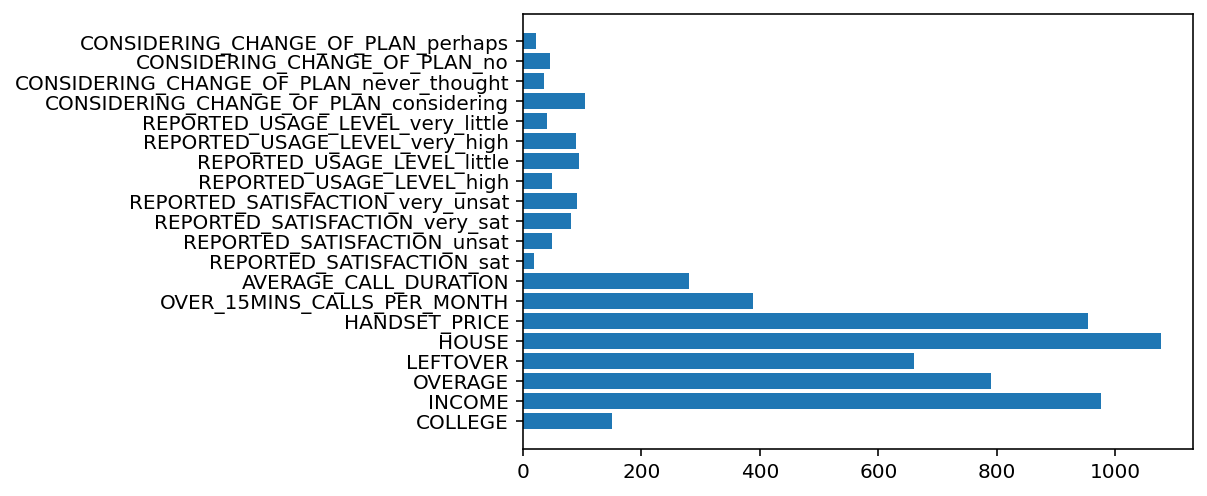

In [68]:
# 변수 중요도 시각화
plt.barh(list(x), width = model.best_estimator_.feature_importances_)
plt.show()

# 7.성능 평가

- 최적 파라미터로 학습된 모델에 대해 최종 성능 평가를 진행합니다.

In [69]:
# 예측하기
y_pred = model.predict(x_test)

In [70]:
# 성능평가
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1386  665]
 [ 545 1404]]
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      2051
           1       0.68      0.72      0.70      1949

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000

